## CNN(Convolution Neural Network)
+ Region Feature을 학습시키기 위한 신경망 모형  
+ 구성요소
  + Region Feature
  + Convolution Laye : Receptive Feild를 정의해 입력 층의 이미지의 Feature을 추출하는 역할을 담당
    - 이미지가 Input으로 들어왔을 때 사각형 모양의 Receptive Field가 이미지를 스캔하면서 이미지의 Region Feature를 추출
    - 이때 이미지의 픽셀 값이 Receptive Field의 Weigt을 거쳐 선형 결합을 통해 1개의 값으로 나옴
    - CNN은 이 Feature을 추출해내는 Weight을 학습시키는 것
  + Stride
  + Padding
  + Weight Sharing
  + Pooling Layer : Feature Size를 줄여주는 역할
    - Pooling Layer는 CNN의 학습속도를 향상시키기위해 Feature의 Dimension을 줄이는 개념이기때문에 정보의 손실이 있을 수 밖에 없음
  + Fully Connected Layer
+ MLP는 이미지의 픽셀값 자체를 바로 Input으로 사용하고,

  CNN은 이미지의 Region Feature을 Convolution Layer와 Pooling Layer을 이용해 추출하고 그 Feature을 MLP의 Input으로 사용하는 것
+ Region Feature, Stride, Pooling 종류, Layer 쌓는 횟수 등 모두 하이퍼파라미터

## CIFAR-10 데이터로 MLP 설계
1. 모듈 임포트
2. 딥러닝 모델 설계 시 활용하는 장비 확인
3. CIFAR-10 데이터 다운로드 후 Train-Test Set 분리
4. 데이터 확인(1)
5. 데이터 확인(2)
6. MLP 설계
7. Optimizer, Objective Function 설정
8. MLP 모델 학습 진행 시, 학습 데이터에 대한 모델의 성능을 확인하는 함수 정의
9. 학습 과정 속 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의
10. MLP 학습을 실행하면서 Train, Test Set의 Loss 및 Test Set Accuracy 확인

### 1. 모듈 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

### 2. 딥러닝 모델 설계 시 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

### 3. CIFAR-10 데이터 다운로드 후 Train-Test Set 분리

In [6]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = False,
                                 download = True,
                                 transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # train_dataset을 미니 배치 단위로 분리해 지정

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False) # train_dataset을 미니 배치 단위로 분리해 지정


Files already downloaded and verified
Files already downloaded and verified


### 4. 데이터 확인(1)

In [7]:
for (X_train, y_train) in train_loader:
  print('X_train :', X_train.size(), 'type :', X_train.type()) # 1
  print('y_train :', y_train.size(), 'type :', y_train.type())
  break

X_train : torch.Size([32, 3, 32, 32]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


+ #1. 32개의 이미지 데이터가 1개의 미니 배치를 구성하고 있고 가로 32, 세로 32의 픽셀로 이루어져 있으며,

  채널이 3이므로 Red, Green, Blue 색상으로 이루어진 컬러 이미지 데이터 임을 확인

### 5. 데이터 확인(2)

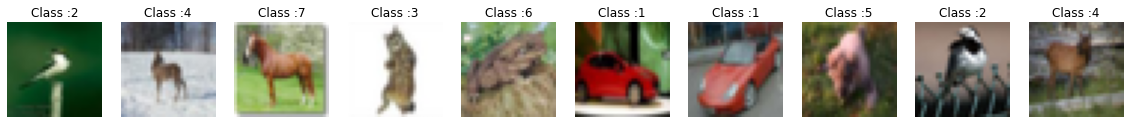

In [26]:
pltsize = 2
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class :' + str(y_train[i].item()))

### 6. MLP 설계

In [33]:
class Net(nn.Module):
  def __init(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 512) # 1
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3) # 2
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1) # 3
    return x

+ #1. 첫번째 Fully Connected Layer 정의
  - CIFAR-10의 데이터를 Input으로 사용하기 때문에 32 * 32 * 3 크기의 노드 수를 설정
  - 두번째 Fully Connected Layer의 노드 수를 512로 설정하기 위해 Output을 512로 설정
+ #2. MLP 모델은 1차원 벡터 값을 입력으로 받을 수 있으므로 

  32 * 32 * 3 크기의 2차원 데이터 인 CIFAR-10 데이터를 View 메서드를 이용해 1차원 데이터로 Flatten
+ #3. softmax를 이용해 0부터 9까지의 Outfut의 확률값을 계산,

  log_softmax()를 이용하는 이유는 Back Propagation을 이용해 학습이 좀 더 원활하게 진행될 수 있도록 하기 위함


### 7. Optimizer, Objective Function 설정

In [32]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # 1
criterion = nn.CrossEntropyLoss() # 2

print(model)

ValueError: ignored

### 8. MLP 모델 학습 진행 시, 학습 데이터에 대한 모델의 성능을 확인하는 함수 정의

In [34]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch : {} [{}/{}({:0f}%)]\tTrain Loss : {:.6f}".format(Epoch,
                                                                           batch_idx * len(image),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

### 9. 학습 과정 속 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의


In [35]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eg(label.view_as(prediction)).sum().item 

  test_loss /= len(test_loader.dataset) 
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

### 10. MLP 학습을 실행하면서 Train, Test Set의 Loss 및 Test Set Accuracy 확인

In [36]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {.2f} % \n".format(
      Epoch,
      test_loss,
      test_accuracy
  ))

NameError: ignored